# Linear models with Scikit-learn

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from pandas.api.types import is_numeric_dtype

from matplotlib import colors 
import colour

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
def normalize(X, ignore=['y']):
    "Normalize variables in a data frame and return unaltered copy"
    X = X.copy(deep=True)
    for colname in X.columns:
        if is_numeric_dtype(X[colname]) and colname not in ignore:
            u = np.mean(X[colname])
            s = np.std(X[colname])
            X[colname] = (X[colname] - u) / s
    return X

## Boston

In [3]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_test, y_test) # bounces around depending on test set

0.8262691790926493

In [6]:
x = [[0.03, 0, 7, 0, 0.47, 7.2, 61.1, 4.97, 2, 242, 17.8, 392, 4]]
lm.predict(x)

array([30.62868464])

In [7]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(lm.score(X_test, y_test))

0.7760601829820746
0.7489723256919159
0.673746213037919
0.66413130887983
0.7393766450296471


In [8]:
# RF has more stable scores and generally better but linear model works well here
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train, y_train)
    print(rf.score(X_test, y_test))

0.7098369317831406
0.665673977653426
0.7779299862480367
0.8353754226144194
0.9007234797931865


## NYC rent data set (Kaggle)

*Data use rules prevent us from storing this data in this repo*. Download the data
set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
and save `train.json` as `rent-train.json`.

In [9]:
def load_rent():
    df = pd.read_json('../../data/rent-train.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [10]:
df_rent = load_rent()
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
111817,1,1.0,40.7302,-73.9924
117995,0,1.0,40.7576,-73.9677
114617,3,2.0,40.7388,-73.9851
117474,1,1.0,40.7939,-73.9738
103891,1,1.0,40.7784,-73.9491


In [11]:
def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    print(f"{n} trials; training {np.mean(train_scores):.3f}, testing {np.mean(test_scores):.3f}")
    if hasattr(model,'coef_'):
        print(f"Coeff {[round(c,2) for c in model.coef_]}")

In [12]:
score(X, y, LinearRegression())

10 trials; training 0.579, testing 0.577
Coeff [447.32, 1483.58, 1229.99, -15657.38]


### Random Forest much stronger than linear model

In [13]:
score(X, y, RandomForestRegressor(n_estimators=10), n=5)

5 trials; training 0.943, testing 0.852


## Adding codependent and noise columns likely doesn't affect predictions

sklearn and other packages remove the codependent features before solving for beta coefficients. Hmm...I thought so but sklearn seems to share coeff values for dup columns and doesn't drop them.  Accuracy is same for this data set anyway, but betas are different.

In [14]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [15]:
score(X, y, LinearRegression(), n=30)

30 trials; training 0.741, testing 0.722
Coeff [-0.12, 0.05, 0.01, 2.87, -20.43, 3.32, 0.01, -1.64, 0.36, -0.01, -1.01, 0.01, -0.55]


In [16]:
score(X, y, Lasso(normalize=True, alpha=.001, max_iter=10_000), n=30)

30 trials; training 0.744, testing 0.710
Coeff [-0.11, 0.04, -0.0, 1.91, -15.23, 4.46, -0.01, -1.33, 0.25, -0.01, -0.91, 0.01, -0.45]


In [17]:
# Add noise columns
for i in range(3):
    X[f'noise{i}'] = np.random.random_sample(len(X))*5
# dup some columns
X['CRIM2'] = X['CRIM']
X['AGE2'] = X['AGE']
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,noise0,noise1,noise2,CRIM2,AGE2
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,2.157810,2.354842,1.607928,0.00632,65.2
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0.515215,1.310094,4.100078,0.02731,78.9
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,4.207057,1.743262,3.437420,0.02729,61.1
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,4.874287,2.545854,2.859936,0.03237,45.8
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,4.646880,3.562081,1.545186,0.06905,54.2


In [18]:
score(X, y, LinearRegression(), n=30)

30 trials; training 0.743, testing 0.726
Coeff [-0.06, 0.05, 0.03, 3.48, -20.77, 3.62, -0.0, -1.61, 0.31, -0.01, -0.95, 0.01, -0.54, 0.03, -0.01, -0.08, -0.06, -0.0]


In [19]:
score(X, y, Lasso(normalize=True, alpha=.0001, max_iter=10_000), n=30)

30 trials; training 0.747, testing 0.700
Coeff [-0.11, 0.04, -0.0, 1.58, -12.93, 4.85, -0.01, -1.24, 0.29, -0.01, -0.87, 0.01, -0.45, 0.09, -0.13, -0.2, -0.0, -0.0]


## Plot residuals

Example: consumption of monthly food budget. When do we run out of pizza money?

In [20]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(1,n,num=n)
df['y'] = [500, 490, 487, 451, 434, 418, 401, 390, 376, 350]
df['y'] = df.y - df.x *2.5 - np.random.uniform(0,50,size=n)

(0.0, 500.0)

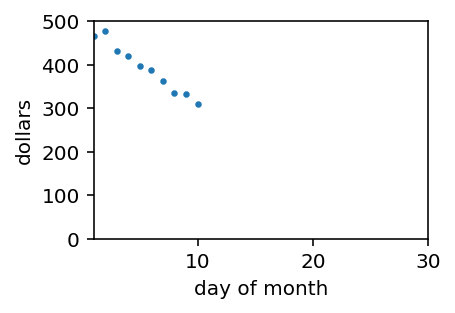

In [21]:
plt.figure(figsize=(3,2))
plt.scatter(df.x, df.y, s=5)
plt.xlabel('day of month')
plt.ylabel('dollars')
plt.xlim(1,30)
plt.ylim(0,500)

In [22]:
def mse(y,y_pred):
    return np.mean( (y - y_pred)**2 )

def line_fit(B, x):
    return B[2-1]*x + B[1-1]

def plot_residuals(x,y,B,xlabel,ylabel,line_xrange=None):
    fig, ax = plt.subplots(figsize=(4,2.5))
    ly = line_fit(B,x)
    ax.scatter(x, y, linewidth=.5, s=15)
    for c,d in zip(x,y):
        plt.plot([c,c],[line_fit(B,c),d], color='red', linewidth=.5)
    if line_xrange is not None:
        lx = np.arange(*line_xrange)
        gline, = plt.plot(lx,line_fit(B,lx),'--',color='grey', linewidth=1)
    else:
        gline, = plt.plot(x,ly,'--',color='grey', linewidth=1)
    loss = mse(ly, y)
    ax.text(17,350, f"Loss is {loss:.2f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right',
            handles=[gline],
           labels=[f"Equation is $y = {B[0]:.1f} + {B[1]:.1f}x$"],
            fontsize=10)

(0.0, 500.0)

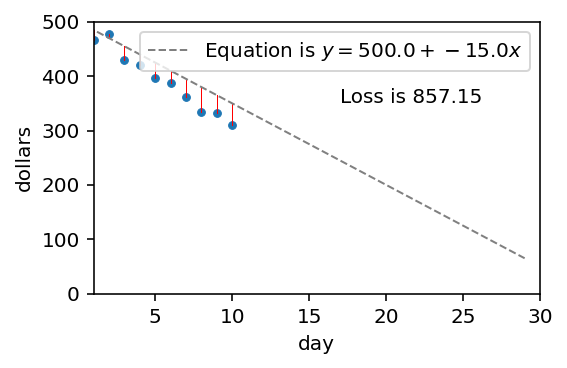

In [23]:
plot_residuals(df.x, df.y, [500,-15], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0.0, 500.0)

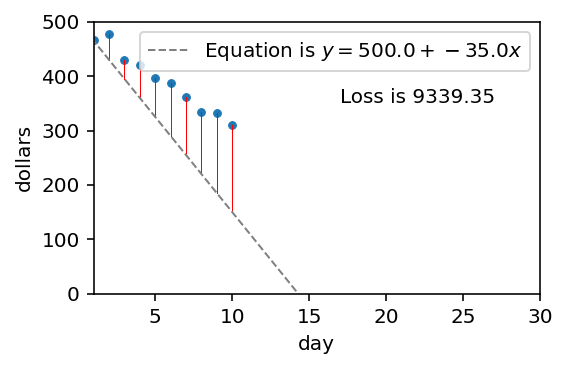

In [24]:
plot_residuals(df.x, df.y, [500,-35], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0.0, 500.0)

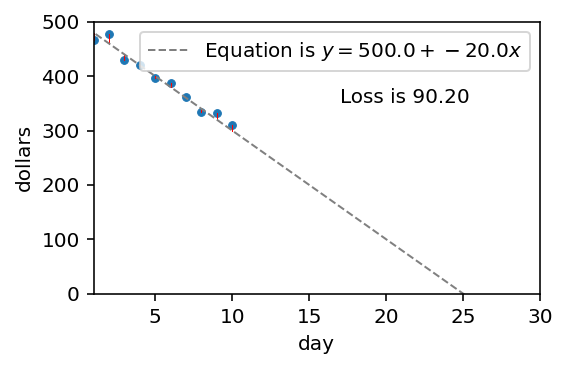

In [25]:
plot_residuals(df.x, df.y, [500,-20], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

## 2D Wine logistic viz

In [242]:
def show(df, features, normalize=False, file=None):
    if normalize:
        df = df.copy()
        df[features[0]] = (df[features[0]]-np.mean(df[features[0]]))/np.std(df[features[0]])
        df[features[1]] = (df[features[1]]-np.mean(df[features[1]]))/np.std(df[features[1]])
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['y']==0]
    df1 = df[df['y']==1]
    ax.scatter(df0[features[0]], df0[features[1]], marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1[features[0]], df1[features[1]], marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    plt.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    plt.show()
    return fig, ax    


def show_decision(model, df, features,
                  threshold=0.5, boundary_tolerance=.01,
                  normalize=False,
                  ax = None,
                  figsize=(4,3),
                  legend_loc='lower right',
                  verbose=True,
                  file=None):
    if normalize:
        df = df.copy()
        df[features[0]] = (df[features[0]]-np.mean(df[features[0]]))/np.std(df[features[0]])
        df[features[1]] = (df[features[1]]-np.mean(df[features[1]]))/np.std(df[features[1]])
        
    X = df[features].values
    y = df['y'].values
    grid = [] # a list of coordinate pairs for the grid
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = np.array(grid)
    proba = model.predict_proba(grid)[:,1]

    if verbose:
        y_proba = model.predict_proba(X)[:,1]
        y_pred = (y_proba>=threshold).astype(int)
        ncorrect = np.sum(y_pred==y)
        accur = ncorrect/len(y)
        prec = precision_score(y,y_pred)
        recall = recall_score(y,y_pred)
        print(f"Accuracy {ncorrect}/{len(y)}={accur:.2f}")
        print(f"(threshold,precision,recall) = ({threshold:.2f},{prec:.3f},{recall:.3f})")

    grid_boundary = grid[np.isclose(proba,threshold,atol=boundary_tolerance)]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    X0 = X[y==0]
    X1 = X[y==1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(proba*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(proba), np.max(proba))
    ax.scatter(grid[:,0], grid[:,1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)
    
    ax.text((max(X[:,0]) + min(X[:,0]))/2,
            max(X[:,1]),
            "$P(y=1|{\\bf x})$>="+f'{threshold:.2f}',
            horizontalalignment='center')


    c0 = ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1, label='class 0')
    c1 = ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, lw=.9, color='#4574B4', alpha=.75, label='class 1')    

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    if legend_loc is not None:
        ax.legend([c0,c1], ['class 0', 'class 1'], loc=legend_loc)
    plt.tight_layout()

In [243]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

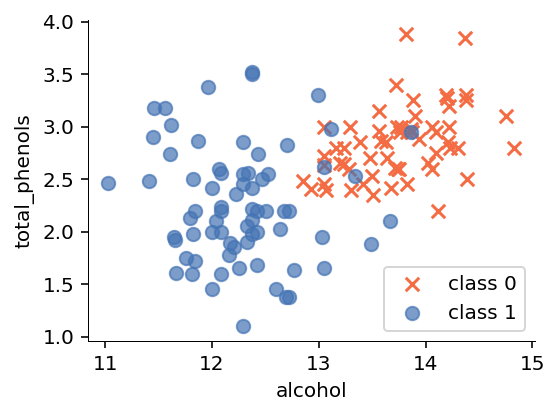

(<Figure size 288x216 with 1 Axes>,
 <AxesSubplot:xlabel='alcohol', ylabel='total_phenols'>)

In [244]:
show(df_wine, features=['alcohol','total_phenols'])

In [245]:
# Just 2 features
features = ['alcohol', 'total_phenols']
X = df_wine[features]
y = df_wine['y']

In [246]:
lg = LogisticRegression(solver='lbfgs')
lg.fit(X,y)
b = np.array([lg.intercept_[0],*lg.coef_[0]]).flatten()
print("coefficients", b)

coefficients [43.21422647 -3.07478185 -1.18771919]


Accuracy 119/130=0.92
(threshold,precision,recall) = (0.50,0.941,0.901)


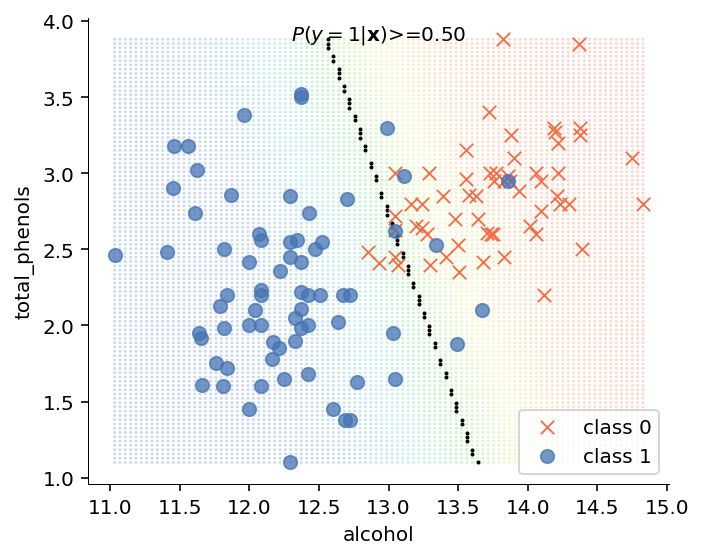

In [247]:
show_decision(lg, df_wine, features=['alcohol','total_phenols'],
              threshold=0.5, boundary_tolerance=0.01, figsize=(5,4))

Accuracy 94/130=0.72
(threshold,precision,recall) = (0.05,0.664,1.000)


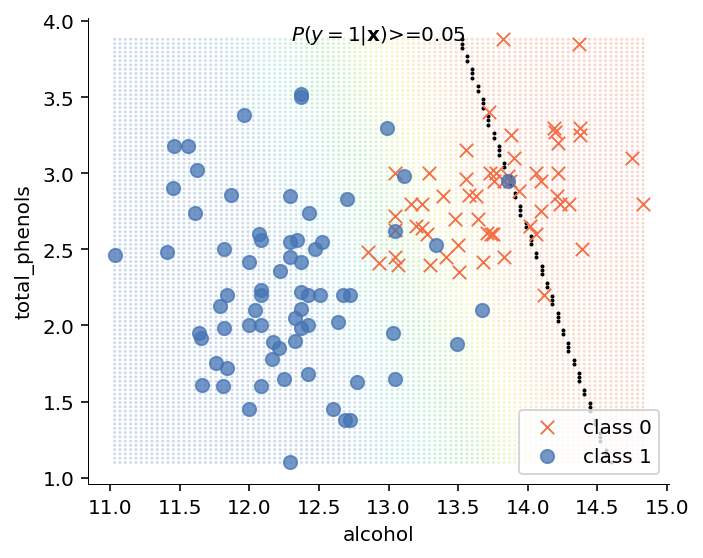

In [248]:
show_decision(lg, df_wine, features=['alcohol','total_phenols'],
              threshold=0.05, boundary_tolerance=0.002, figsize=(5,4))

Accuracy 109/130=0.84
(threshold,precision,recall) = (0.90,1.000,0.704)


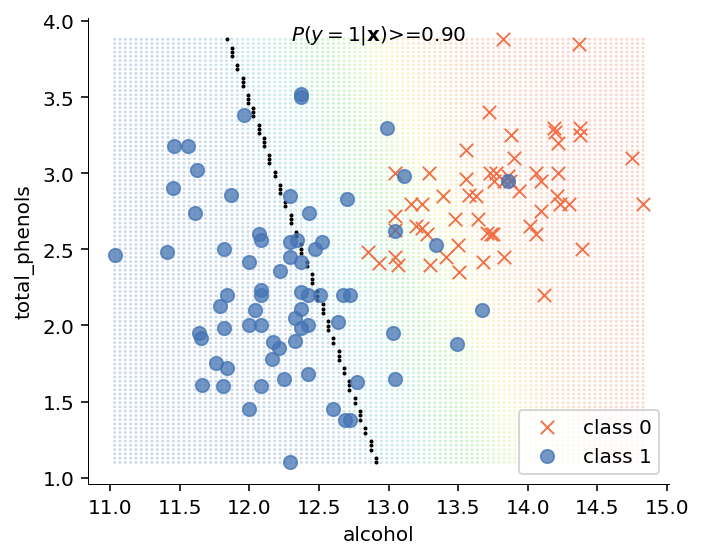

In [249]:
show_decision(lg, df_wine, features=['alcohol','total_phenols'],
              threshold=0.9, boundary_tolerance=0.004, figsize=(5,4))

### Animation

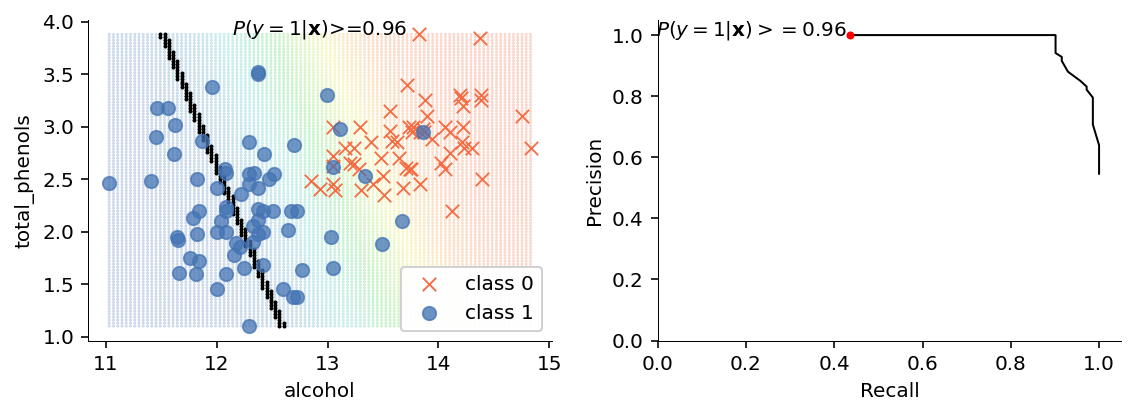

In [250]:
from celluloid import Camera
from IPython.display import HTML

fig, axes = plt.subplots(1,2,figsize=(8,3))

camera = Camera(fig)

p_history = []
r_history = []

for threshold in np.arange(0.001,0.99,step=.04):
    show_decision(lg, df_wine, features=['alcohol','total_phenols'],
                  threshold=threshold, boundary_tolerance=0.004,
                  ax=axes[0],
                  figsize=(5,4),
                  verbose=False
                 )
    
    y_proba = lg.predict_proba(X)[:,1]
    y_pred = (y_proba>=threshold).astype(int)
    ncorrect = np.sum(y_pred==y)
    accur = ncorrect/len(y)
    prec = precision_score(y,y_pred)
    recall = recall_score(y,y_pred)
#     print(f"Accuracy {ncorrect}/{len(y)}={accur:.2f}")
#     print(f"(threshold,precision,recall) = ({threshold:.2f},{prec:.3f},{recall:.3f})")

    p_history.append(prec)
    r_history.append(recall)
    axes[1].plot(r_history,p_history,'-',color='k',linewidth=1)
    axes[1].plot(recall,prec,'.',color='red')
    axes[1].text(recall*.98,prec,"$P(y=1|{\\bf x})>=$"+f'{threshold:.2f}',
                 horizontalalignment='right')

    axes[1].spines['top'].set_visible(False)    # turns off the top "spine" completely
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['left'].set_linewidth(.5)
    axes[1].spines['bottom'].set_linewidth(.5)
    axes[1].set_xlim(0,1.05)
    axes[1].set_ylim(0,1.05)
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    camera.snap()

animation = camera.animate()
animation.save('/tmp/wine.gif',dpi=200)
#HTML(animation.to_html5_video())

### Normalized

In [181]:
df_ = normalize(df_wine)

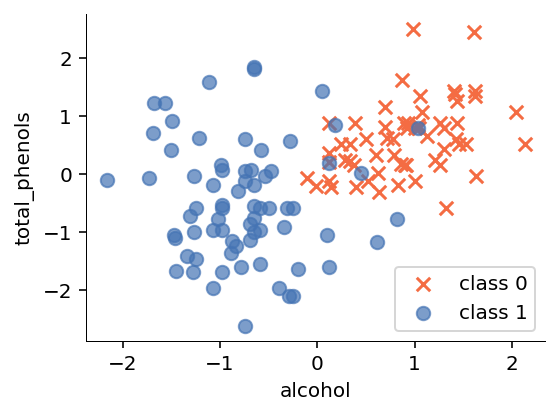

(<Figure size 288x216 with 1 Axes>,
 <AxesSubplot:xlabel='alcohol', ylabel='total_phenols'>)

In [182]:
show(df_, features=['alcohol','total_phenols'])

In [183]:
X_ = df_[features]
y = df_['y']
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_,y)
b = np.array([lg.intercept_[0],*lg.coef_[0]]).flatten()
print("coefficients", b)

coefficients [ 0.45154295 -2.85029574 -0.82874965]


Accuracy 119/130=0.92
(threshold,precision,recall) = (0.50,0.941,0.901)


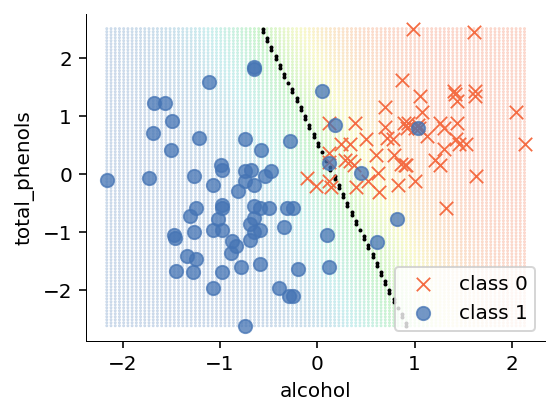

In [184]:
show_decision(lg, df_, features=['alcohol','total_phenols'],
              threshold=0.5, boundary_tolerance=0.01)

### 1D alcohol vs class 0,1

In [185]:
def plot12(X,y):
    X_1 = X[y==0]
    X_2 = X[y==1]

    fig, ax = plt.subplots(figsize=(4.8,1.8))
    ax.scatter(X_1, [0]*len(X_1), s=20, alpha=.8, label='class0')
    ax.scatter(X_2, [1]*len(X_2), s=20, alpha=.8, label='class1')

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    ax.set_xlabel('alcohol')
    ax.set_ylabel('class')
    ax.set_yticks([0,1])
    plt.legend(loc='lower left', fontsize=9)
    plt.tight_layout()
    plt.title("1D wine data set, classes 0,1", fontsize=10)

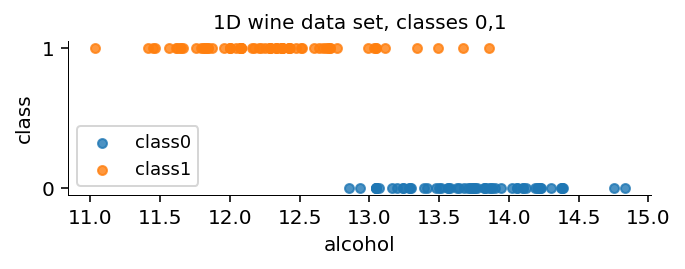

In [186]:
X = df_wine.drop('y', axis=1)
X = X['alcohol']
y = df_wine['y']
plot12(X,y)

Text(0.5, 1.0, 'Linear model prediction of int target $y$')

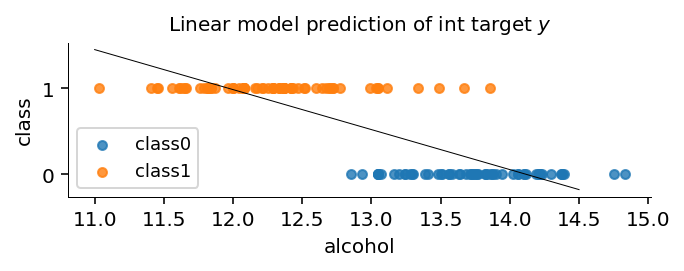

In [187]:
X_ = X.values.reshape(-1,1)
lm = LinearRegression()
lm.fit(X_, y)
plot12(X,y)
#print(lm.coef_, lm.intercept_)
lx = np.linspace(11,14.5).reshape(-1,1)
plt.plot(lx, lm.predict(lx), lw=.5, c='k')
plt.title("Linear model prediction of int target $y$",
         fontsize=10)

In [188]:
X_ = X.values.reshape(-1,1)
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_,y)
b = np.array([lg.intercept_,lg.coef_[0]]).flatten().astype(float)
print("coefficients", b)

coefficients [43.62176958 -3.33623271]


Text(0.5, 1.0, 'Logistic model prediction of int target $y$')

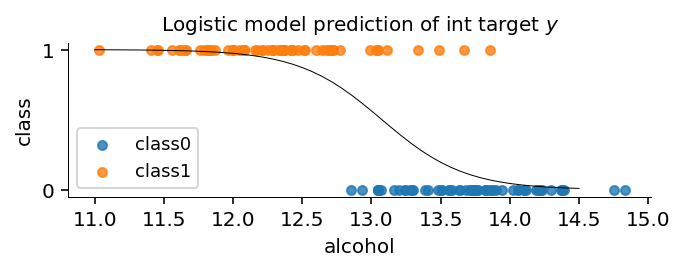

In [189]:
plot12(X,y)
lx = np.linspace(11,14.5).reshape(-1,1)
plt.plot(lx, lg.predict_proba(lx)[:,1], lw=.5, c='k')
plt.title("Logistic model prediction of int target $y$",
         fontsize=10)

## Logistic regression using matrix arithmetic

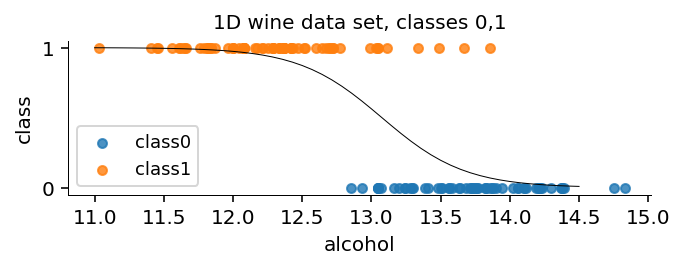

In [43]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

plot12(X,y)

B0 = np.ones(shape=(len(lx), 1))
X1 = np.hstack([B0, lx]).astype(float)

y_pred = np.dot(X1,b)

plt.plot(lx, sigmoid(y_pred), lw=.5, c='k')